In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("ticks")
sns.set_context(context="talk")

## READ DATA IN FROM GOOGLE DOCS ##
# see http://gspread.readthedocs.io/en/latest/oauth2.html
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('/Users/urai/Documents/stuff/IBL-CSHL-citricAcid-dc4fee22cc42.json', scope)
gc = gspread.authorize(credentials)

# now read the doc
doc = gc.open_by_key('1Ne466FpvhqbMQIfuivZRhp_3alBVTgPGSMc0q387frk')

In [48]:
# read all worksheets, make a dictionary with the info that we'll need to add
worksheet_list = [
    {"sheet": "Batch1", "baseline": "free hydrogel", "intervention": "citric acid water"},
    {"sheet": "Batch2", "baseline": "water restriction", "intervention": "citric acid water"},
    {"sheet": "Batch3", "baseline": "free hydrogel", "intervention": "citric acid hydrogel"},
    {"sheet": "Batch4", "baseline": "water restriction", "intervention": "citric acid hydrogel"}]

results = []
for w, entry in enumerate(worksheet_list):
    worksheet = doc.worksheet(entry["sheet"])
    df = pd.DataFrame(worksheet.get_all_records())
    df.drop([''], axis=1, inplace=True) # get rid of extra stuff
    
    # make the date relative to baseline (1st entry)
    df['date'] = pd.to_datetime(df.date)
    df['date'] = df.date - df.date[0]

    # unstack https://deparkes.co.uk/2016/10/28/reshape-pandas-data-with-melt/
    df = pd.melt(df, id_vars=["date", "concentration"], var_name="mouse", value_name="weight")

    # add some info about the different batches
    df['baseline'] = entry["baseline"]
    df['intervention'] = entry["intervention"]
    df['group'] = entry["baseline"] + ", " + entry["intervention"]
    results.append(df)

# append across worksheets
data = pd.concat(results, ignore_index=True)

# clean up
data.dropna(subset=['weight', 'date'], inplace=True)
data['days'] = data.date.dt.days # convert to number of days from start of the experiment
data['weight'] = pd.to_numeric(data['weight'], errors='coerce') # force all values into floats
data['concentration'] = pd.to_numeric(data['concentration'], errors='coerce') # force all values into floats
data.sample(n=5)

,date,concentration,mouse,weight,baseline,intervention,group,days
173,3 days,1,IBL_20,23.60,water restriction,citric acid water,"water restriction, citric acid water",3
260,2 days,1,IBL_11,30.00,free hydrogel,citric acid hydrogel,"free hydrogel, citric acid hydrogel",2
156,6 days,1,IBL_18,22.80,water restriction,citric acid water,"water restriction, citric acid water",6
327,0 days,0,IBL_16,22.57,water restriction,citric acid hydrogel,"water restriction, citric acid hydrogel",0
122,2 days,1,IBL_5,28.70,free hydrogel,citric acid water,"free hydrogel, citric acid water",2


In [49]:
# add a weight that's normalized by the first day of each mouse
def pct_change(df):
    df['weight_change'] = df['weight'] / df.loc[df['days'] == 0, 'weight'].mean()
    return df
data = data.groupby(['mouse']).apply(pct_change)

/anaconda3/envs/python3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


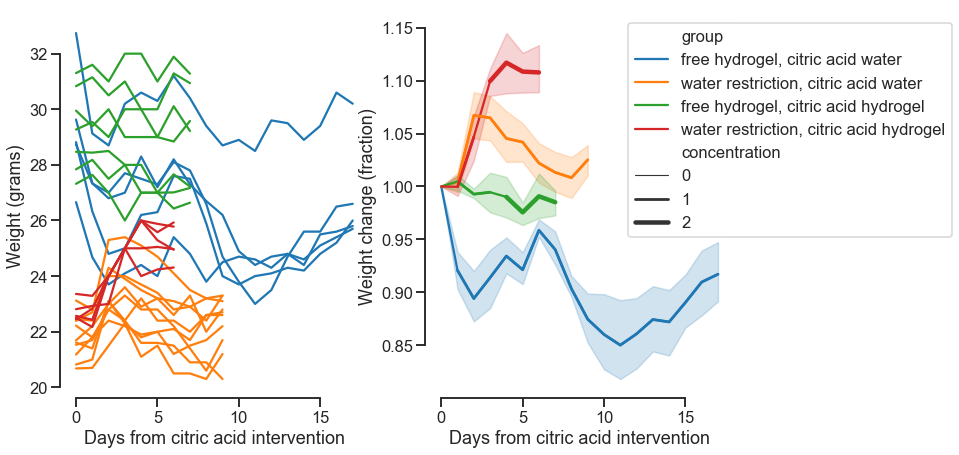

In [63]:
## NOW PLOT WITH SEABORN
f, ax = plt.subplots(1,2, sharex=True, figsize=(12, 7))

sns.lineplot(x="days", y="weight", hue="group", 
                  estimator=None, units="mouse", data=data, ax=ax[0])
ax[0].set(ylabel="Weight (grams)", xlabel="Days from citric acid intervention")
ax[0].legend_.remove()

# same, but with weight as % from baseline
sns.lineplot(x="days", y="weight_change", hue="group", data=data, ax=ax[1], legend=False)
sns.lineplot(x="days", y="weight_change", hue="group", size="concentration", ci=None, data=data, ax=ax[1])
ax[1].set(ylabel="Weight change (fraction)", xlabel="Days from citric acid intervention")
ax[1].legend(loc='center right', bbox_to_anchor=(1.75, 0.7), ncol=1) # move box outside
sns.despine(offset=2, trim=True)